# PXD011691 BGS TMT Data

## Quality Control (QC) notebook

### prepared by Phil Wilmarth, PSR Core OHSU

#### February 20, 2023

---

- [Overview](#overview) 
- [Data loading](#load_data)
- [TMM normalization and final clustering](#TMM)
- [CV distributions](#CVs)
- [Sample-to-sample scatter plots](#scatter_plots)
- [Summary](#summary)

---

## <a name="overview"></a>Overview

Data from the 10-fraction TMT part of [PXD011691](http://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD011691) described in [this paywalled paper](https://pubs.acs.org/doi/abs/10.1021/acs.jproteome.8b00898). The paper nominally compares single-shot DIA analyses (library and library-free with [Spectronaut](https://biognosys.com/software/spectronaut/)) to fractionated TMT-labeled analyses. The number of fractions for the TMT experiment was designed to use a similar total LC-MS time as the single-shot method. The samples were predominantly digests of 10 purchased mouse brain samples. 

All the wet bench work was done at one lab. The final mass spec samples for the low-pH reverse phase chromatography runs were split and two laboratories generated data from the same instrument models. The two lab datasets are, in essence, LC-MS technical replicates. One possible data comparison is between the two labs by either DIA or TMT methods.

Each lab did the DIA and TMT experiments. Another comparison would be between DIA and TMT from each lab site. The samples are the same and the study designs, while different, are how studies with each method would typically be done. The "proteome" comparison is challenging for several reasons. We need to define what we mean by proteomes. We need to create and describe procedures for comparing proteomes. We do not know how similar or different single shot versus fractionated proteomes are if we used only one quantitative proteomics technique. We do not know if proteomes from DIA are similar to DDA proteomes. We do not know how stable isotope labeled proteomes compare to label-free proteomes. We do not know how different data analysis pipelines affect proteomes. This is a difficult problem.

The publication also spiked-in human UPS2 protein digests to the mouse background. Much of the paper focuses on concepts of accuracy and precision using the UPS2 proteins. However, the spike-in design is poor (a common theme among spike-in experimental designs), and the data is not worth the time to analyize. Major flaws in the spike-in experiment are high homology between human and mouse house-keeping proteins (the UPS proteins are mostly common house-keeping proteins), picking UPS2 instead of UPS1 (UPS2 has proteins in groups of 8 that have 5 decades of concentration difference), doing 5 dilutions of a spike-in sample that already has dilutions (kind of a dilution squared situation) for 10 samples (comparisons are n=2 cases), and very low levels of UPS2 proteins that compromise detectability (only 12-19 of the 48 proteins could be detected). The UPS2 spike-in is an unnecessary distraction.    

This notebook looks at the TMT data from the Biognosys (BGS) lab. 

#### Sample Key:

This is a guessed sample key based on the total intensity of UPS2 proteins to the total intensity of mouse proteins for each TMT channel (after excluding decoys and contaminants).

TMT10 Label Reagent|Sample_ID
:---:|:---
126C|S4-1 
127N|S2-1  
127C|S5-1  
128N|S4-2 
128C|S3-1  
129N|S2-2  
129C|S3-2
130N|S1-1 
130C|S5-2
131N|S1-2

--- 

Data were reprocessed with the [PAW Pipeline](https://github.com/pwilmart/PAW_pipeline) (*Wilmarth 2009*) using a current canonical mouse sequence collection (from UniProt with 21K sequences). There were several issues with the Proteome Discoverer v2.2 TMT data presented in the paper. The FASTA file for mouse was the somewhat incomplete UniProt Swiss-Prot (less than 17K sequences from 2016), Mascot was used for PSM identification of the low-res ion trap data in the SPS-MS3 method with so-so parameters, signal-to-noise ratios were used for reporter ions (measurements have units, folks), the protein inference method in PD was not described, and the sample key (what TMT tags were used for the samples) was not specified (neither in the paper nor the repository).   

This notebook will explore these questions:

- What does the starting data look like?
- Are TMM normalization factors small and consistent?
- Are mouse proteins in the samples similar to each other?

### References

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

# =========== Boxplot with median label ========================================
labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

## <a name="load_data"></a>Load the TMT intensity data

We prepped the data in Excel to remove contaminant and decoy proteins, and proteins with missing sets of reporter ions.

In [3]:
# load the IRS-normalized data and check the table
start_data_all <- read_tsv("BGS-quant-table.txt")

# make a data frame without the UPS2 proteins
start_data_mouse <- start_data_all %>% filter(!grepl('EXTRA_', Accession))

Parsed with column specification:
cols(
  Accession = col_character(),
  `S4-1` = col_double(),
  `S2-1` = col_double(),
  `S5-1` = col_double(),
  `S4-2` = col_double(),
  `S3-1` = col_double(),
  `S2-2` = col_double(),
  `S3-2` = col_double(),
  `S1-1` = col_double(),
  `S5-2` = col_double(),
  `S1-2` = col_double()
)



In [4]:
# save gene names for edgeR so we can double check that results line up
accessions_all <- start_data_all$Accession
accessions_mouse <- start_data_mouse$Accession

# drop the accession column
start_data_all  <- start_data_all[-1]
start_data_mouse <- start_data_mouse[-1]

# see how many rows of data we have
nrow(start_data_all)
nrow(start_data_mouse)

[1] 6539

[1] 6521

## Check the starting data

We can use either the data with or without the 18 UPS2 proteins. They are in low abundances and will not affect distribution box plots. We will do it both ways to show that the UPS2 proteins don't change things.

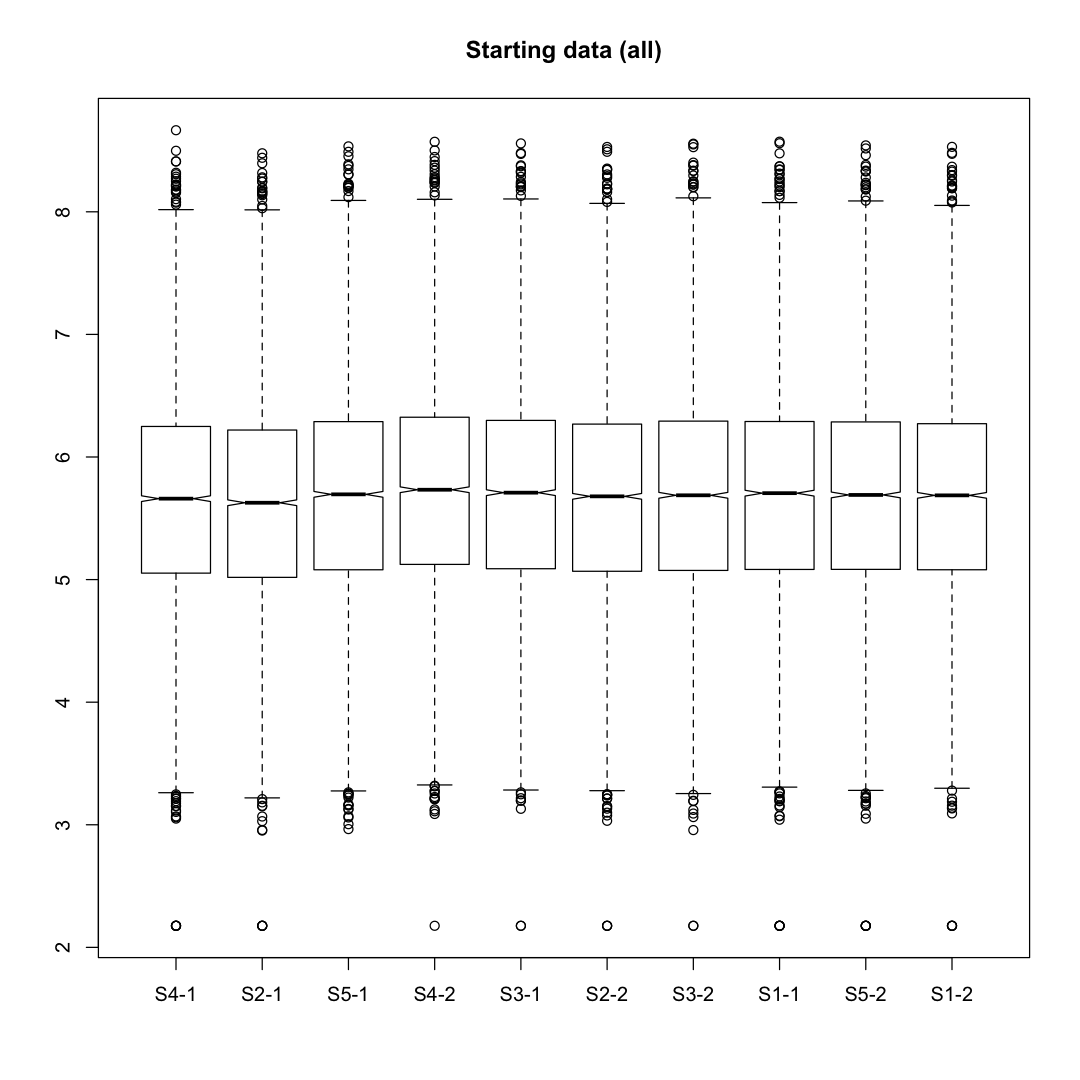

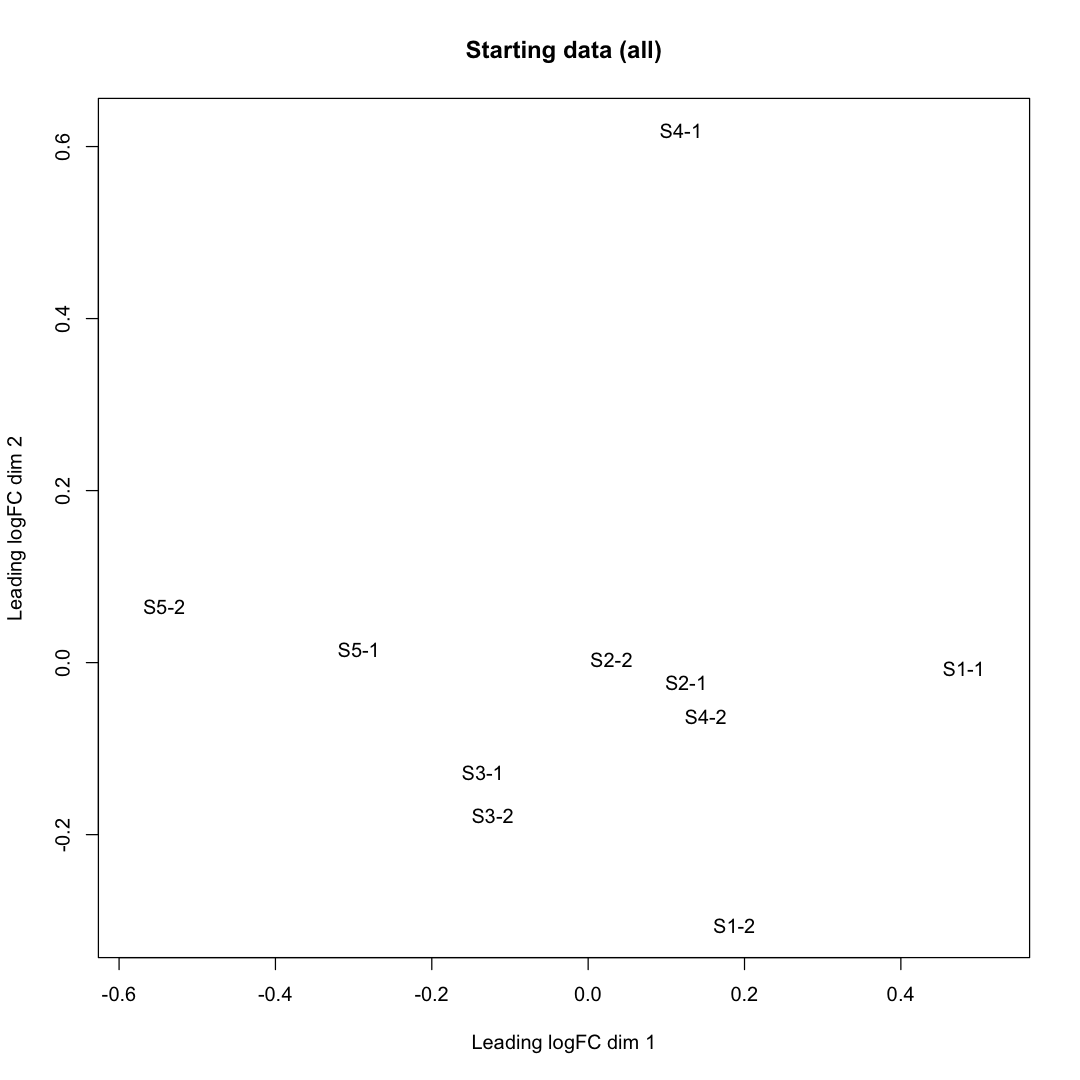

In [5]:
# make plots a little larger
set_plot_dimensions(9, 9)

# plot the starting data
boxplot(log10(start_data_all), notch = TRUE, main = "Starting data (all)")

# check the clustering
plotMDS(log2(start_data_all), main = "Starting data (all)")

### Starting data looks okay

The starting data is already pretty well matched between channels without any normalization. We will look at the mouse proteins only next.

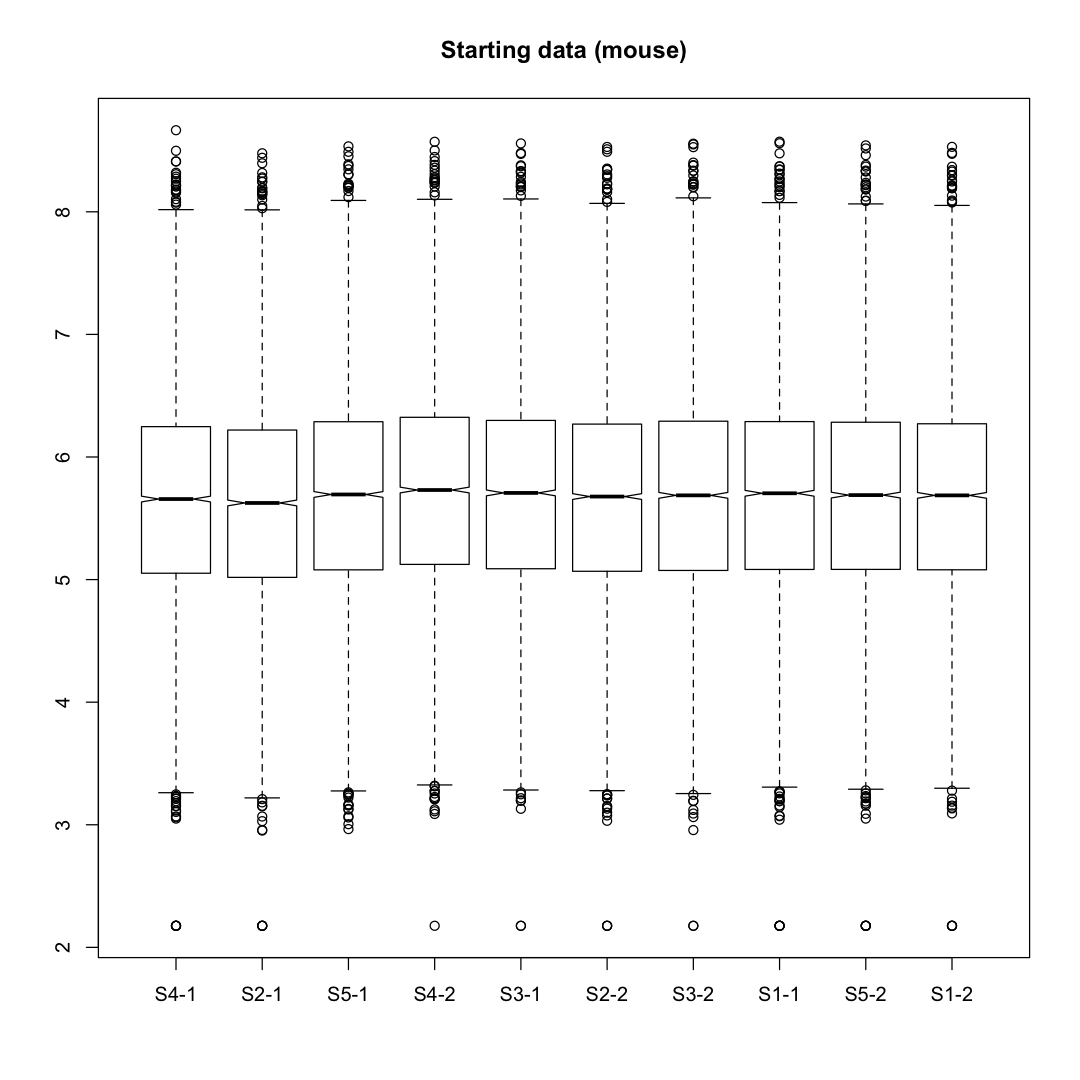

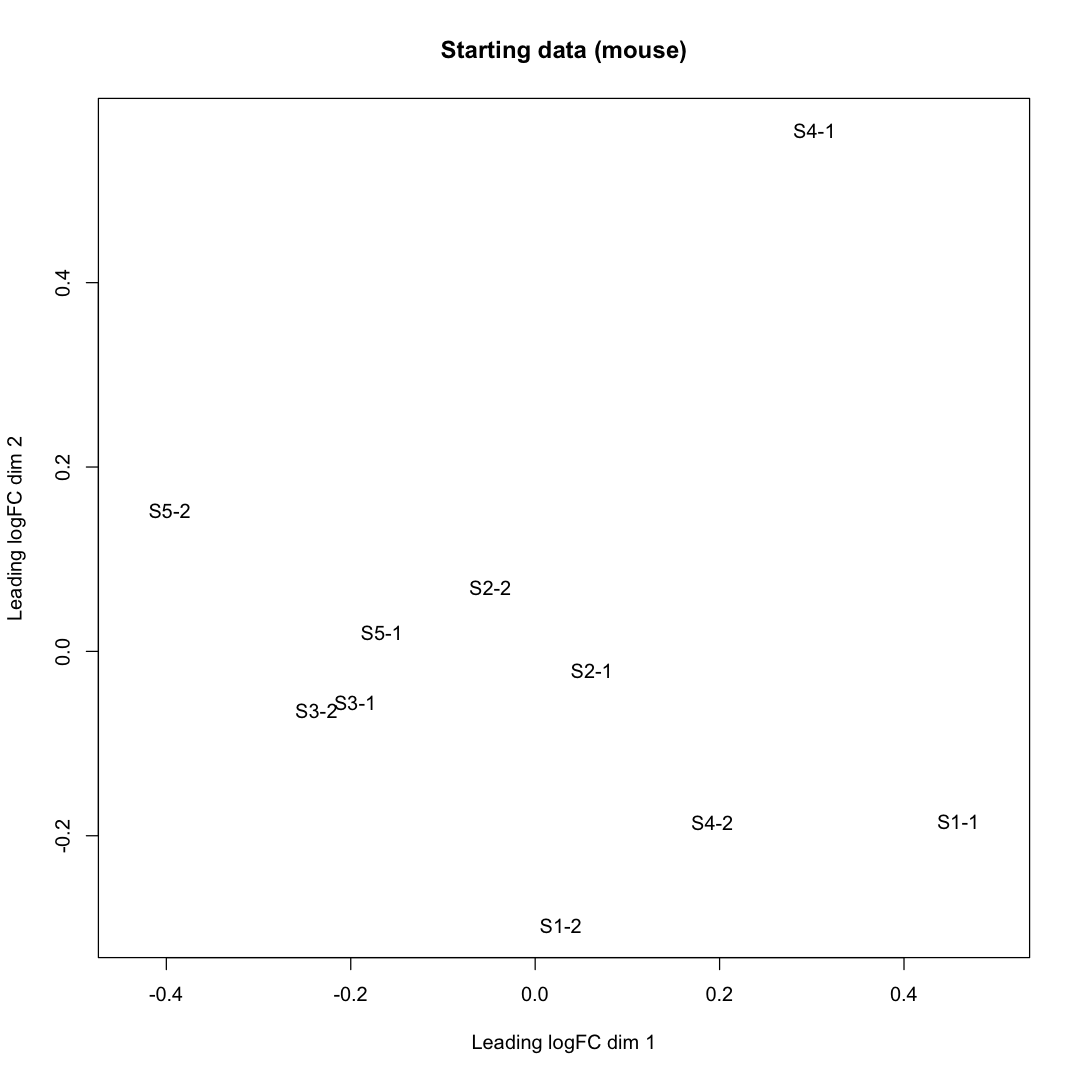

In [6]:
# plot the starting data for mouse proteins
boxplot(log10(start_data_mouse), notch = TRUE, main = "Starting data (mouse)")

# check the clustering
plotMDS(log2(start_data_mouse), main = "Starting data (mouse)")

### Mouse proteins only look the same

These global distribution metrics are not going to be affected by 18 lower abundance proteins (UPS2) out of 6,500 (mouse).

## <a name="TMM"></a>Run TMM normalization and check final clustering 

We will load the data into edgeR data structures and call the `calcNormFactors` function to perform library size and the trimmed mean of M-values (TMM) normalization to correct for any sample composition differences.

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

We need to use the edgeR normalization factors to produce the TMM normalized data that the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We compute the normalized intensities with the `apply_tmm_factors function`.


Library size factors:
 S4-1  -> 1.059976
 S2-1  -> 1.150269
 S5-1  -> 0.979796
 S4-2  -> 0.917406
 S3-1  -> 0.977217
 S2-2  -> 1.023185
 S3-2  -> 0.954413
 S1-1  -> 0.969273
 S5-2  -> 0.979937
 S1-2  -> 1.024613

Trimmed mean of M-values (TMM) factors:
 S4-1  -> 1.022149
 S2-1  -> 1.001914
 S5-1  -> 1.001408
 S4-2  -> 0.986795
 S3-1  -> 0.983059
 S2-2  -> 0.991442
 S3-2  -> 1.022179
 S1-1  -> 1.008995
 S5-2  -> 1.003409
 S1-2  -> 0.979663

Combined (lib size and TMM) normalization factors:
 S4-1  -> 1.083454
 S2-1  -> 1.152471
 S5-1  -> 0.981176
 S4-2  -> 0.905292
 S3-1  -> 0.960662
 S2-2  -> 1.014429
 S3-2  -> 0.975581
 S1-1  -> 0.977991
 S5-2  -> 0.983278
 S1-2  -> 1.003776


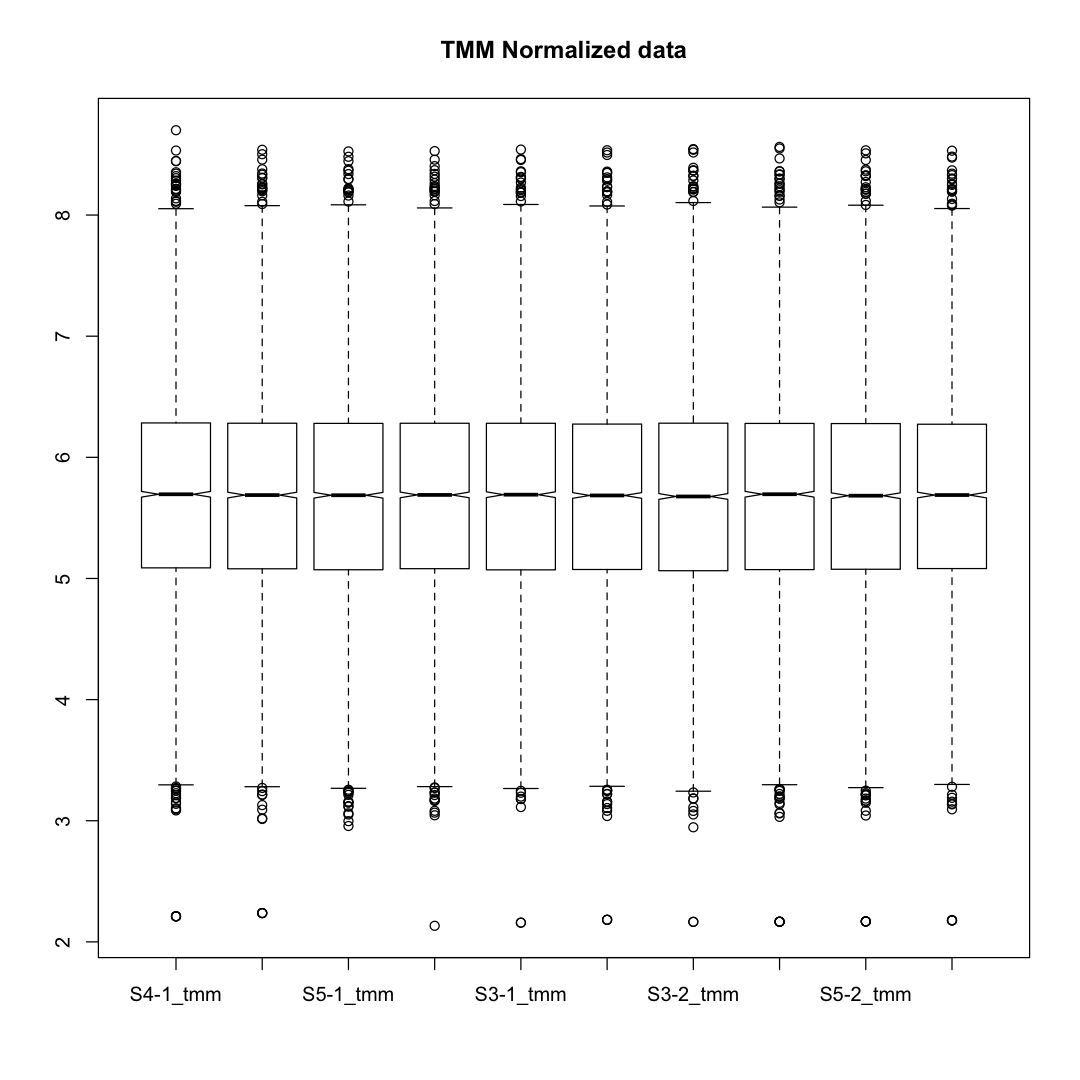

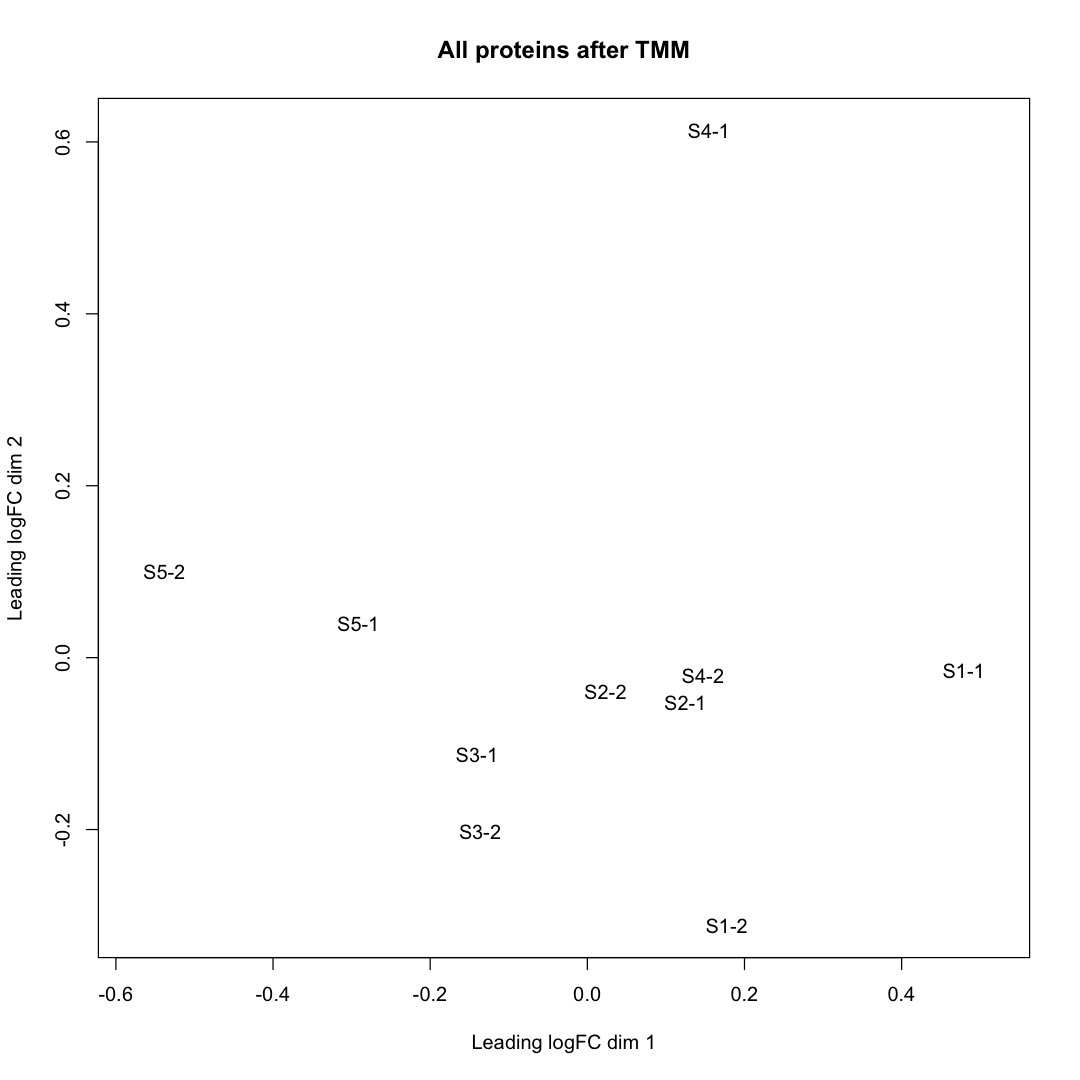

In [7]:
# get the biological sample data into a DGEList object
group = c("S4-1", "S2-1", "S5-1", "S4-2", "S3-1", "S2-2", "S3-3", "S1-1", "S5-2", "S1-2")
y_all <- DGEList(counts = start_data_all, group = group, genes = accessions_all)

# run TMM normalization (also includes a library size factor)
y_all <- calcNormFactors(y_all)

# compute the TMM-normalized intensities
tmt_tmm_all <- apply_tmm_factors(y_all)

# check the clustering
plotMDS(y_all, main = "All proteins after TMM")


Library size factors:
 S4-1  -> 1.059543
 S2-1  -> 1.149036
 S5-1  -> 0.983242
 S4-2  -> 0.916908
 S3-1  -> 0.976421
 S2-2  -> 1.021963
 S3-2  -> 0.953412
 S1-1  -> 0.967960
 S5-2  -> 0.983895
 S1-2  -> 1.023284

Trimmed mean of M-values (TMM) factors:
 S4-1  -> 1.019166
 S2-1  -> 1.001136
 S5-1  -> 0.998251
 S4-2  -> 0.985822
 S3-1  -> 0.984991
 S2-2  -> 0.992781
 S3-2  -> 1.024714
 S1-1  -> 1.011482
 S5-2  -> 1.000683
 S1-2  -> 0.981930

Combined (lib size and TMM) normalization factors:
 S4-1  -> 1.079850
 S2-1  -> 1.150342
 S5-1  -> 0.981522
 S4-2  -> 0.903909
 S3-1  -> 0.961766
 S2-2  -> 1.014586
 S3-2  -> 0.976974
 S1-1  -> 0.979075
 S5-2  -> 0.984567
 S1-2  -> 1.004793


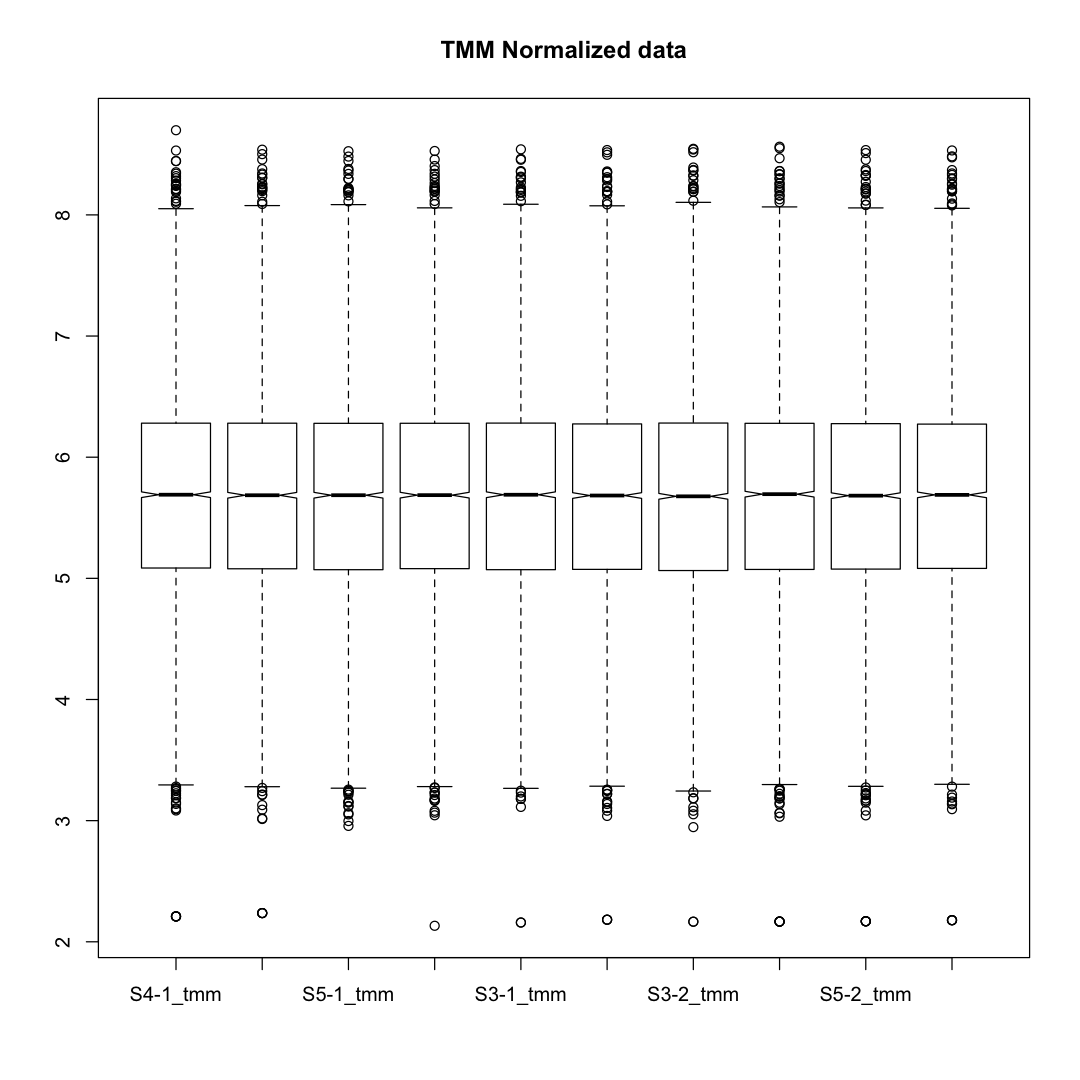

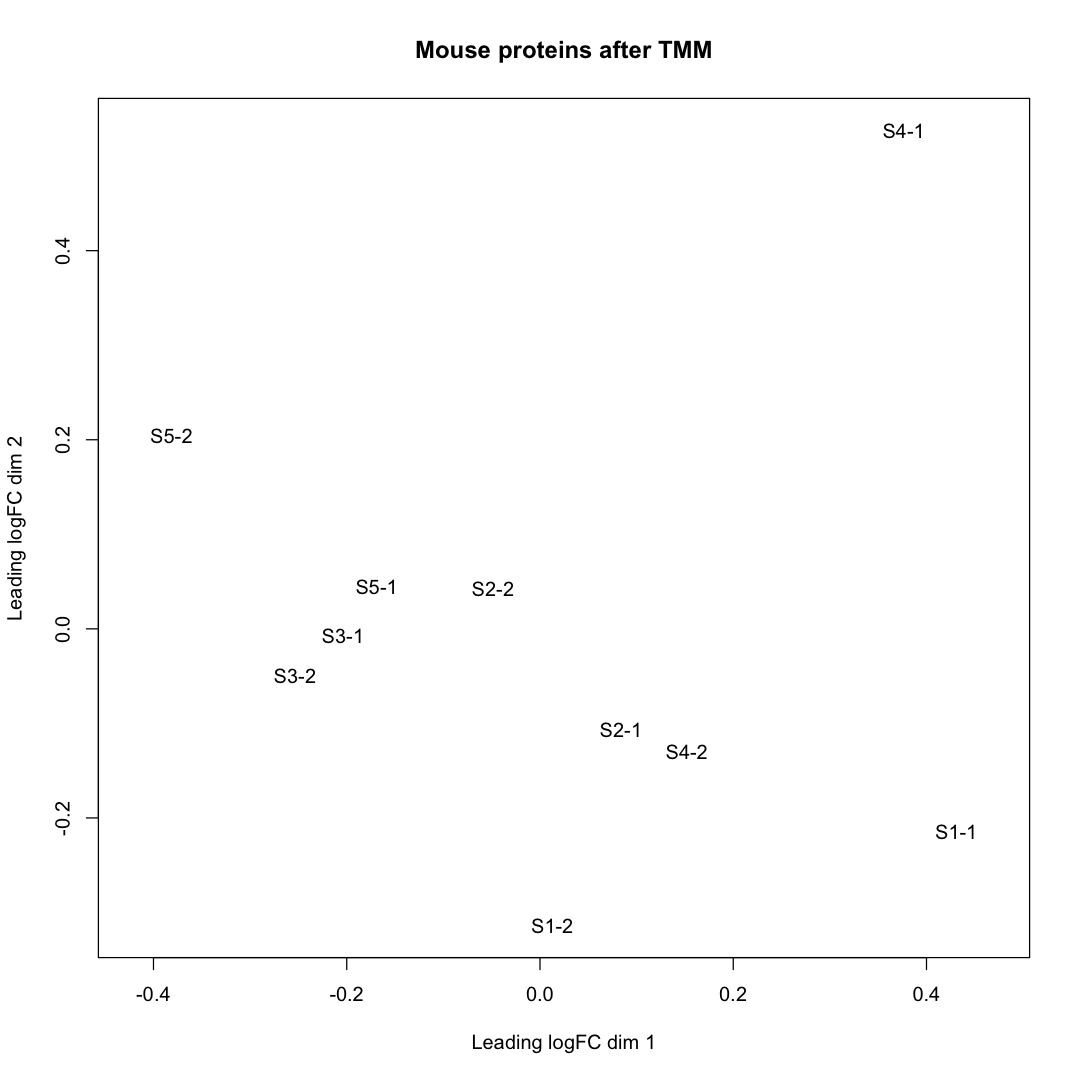

In [8]:
# load the edgeR data objects
y_mouse <- DGEList(counts = start_data_mouse, group = group, genes = accessions_mouse)

# run TMM normalization (also includes a library size factor)
y_mouse <- calcNormFactors(y_mouse)

# compute the TMM-normalized intensities
tmt_tmm_mouse <- apply_tmm_factors(y_mouse)

# check the clustering
plotMDS(y_mouse, main = "Mouse proteins after TMM")

### Most TMM factors are very close to 1.0 

The library size normalizations match the grand total intensities across the samples. We could still have compositional differences between sample groups that would result in TMM factors (the second table) being farther from 1. All the TMM factors (the second block of numbers above) are close to 1.0 indicating similar composition for all samples. 

Box plot horizontal alignment is better. The clustering looks similar before and after TMM normalization. 

## <a name="CVs"></a>Check CV distributions

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This is an effective way to assess proper normalization in these experiments. We will compute CV distributions for all proteins (dropping the 18 UPS2 proteins will not change anything).

In [9]:
# put CVs in data frames to simplify plots and summaries
cv_start_all <- data.frame(all = CV(start_data_all))

cv_tmm_all <- data.frame(all = CV(tmt_tmm_all))

# see what the median CV values are
medians <- apply(cv_start_all, 2, FUN = median)
print("Starting median CVs by condition (%)")
round(medians, 2)

medians <- apply(cv_tmm_all, 2, FUN = median)
print("Final median CVs by condition (%)")
round(medians, 2)

[1] "Starting median CVs by condition (%)"


all 
8.83

[1] "Final median CVs by condition (%)"


all 
5.77

### Median CVs improve

The average median CV goes from 8.8% to 5.8%. TMM normalization tightens up the data.

## Use ggplot to visualize the CV distributions

We will just compare the starting data to the final TMM normalized data here. We will use the set of all proteins (it won't matter with or without the UPS2 proteins).

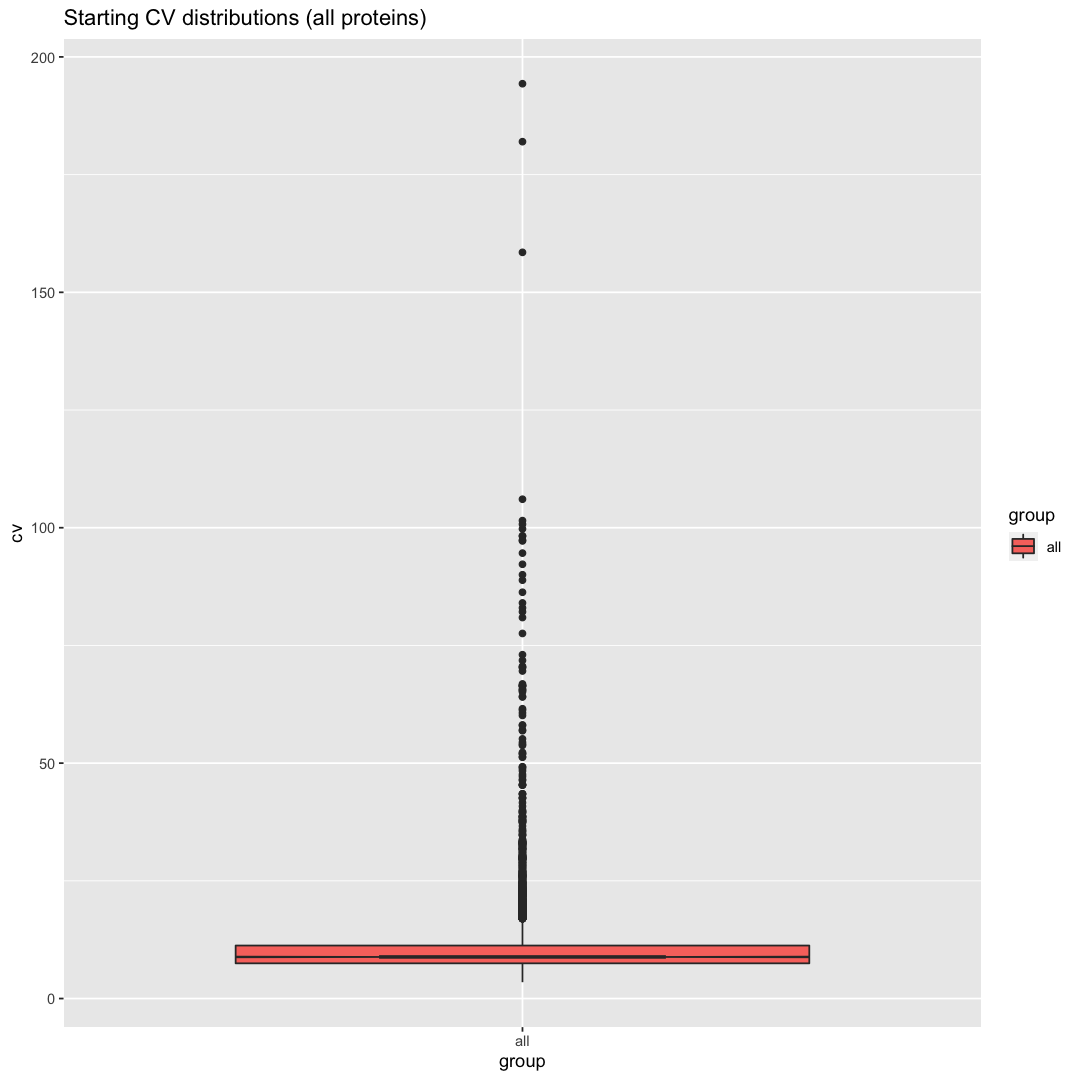

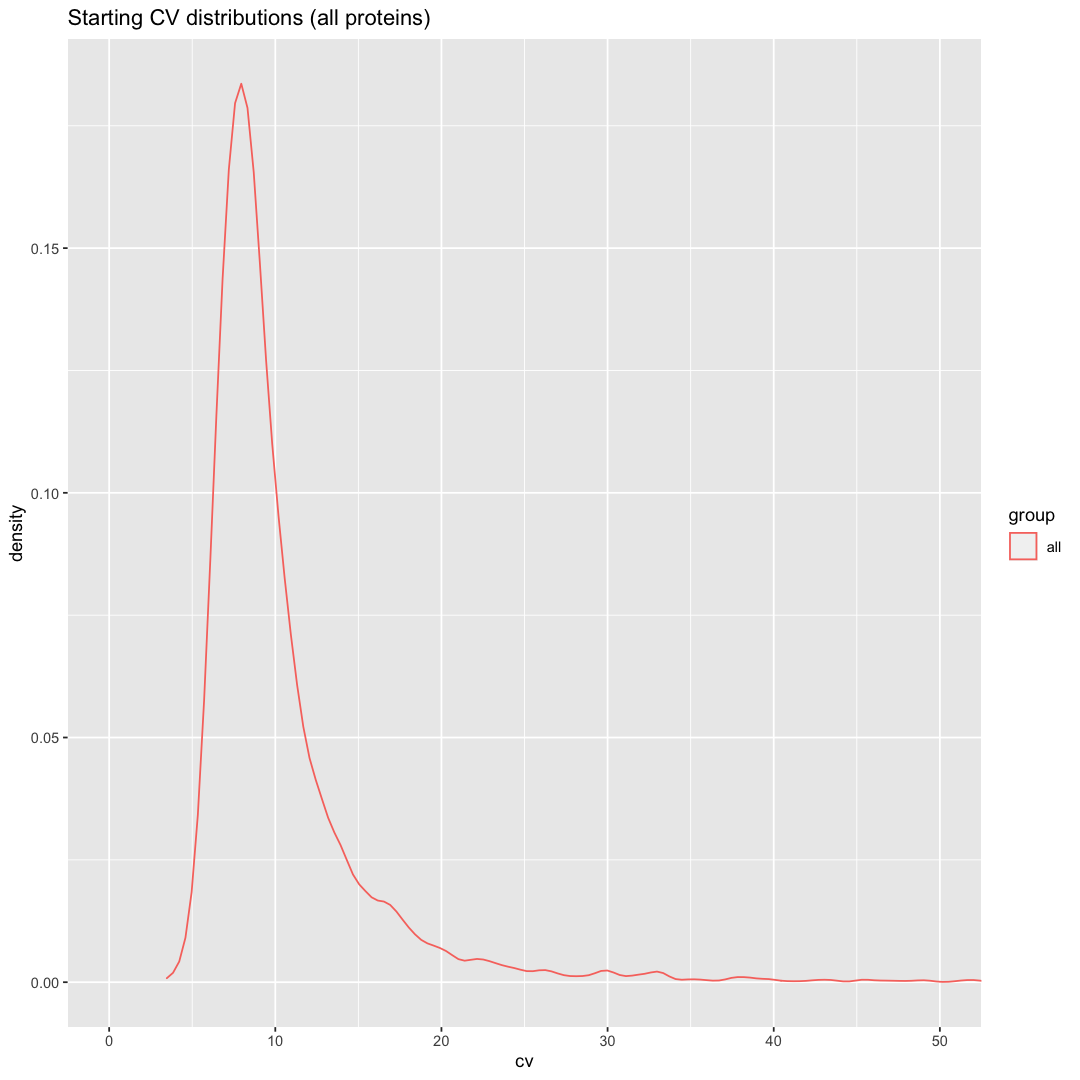

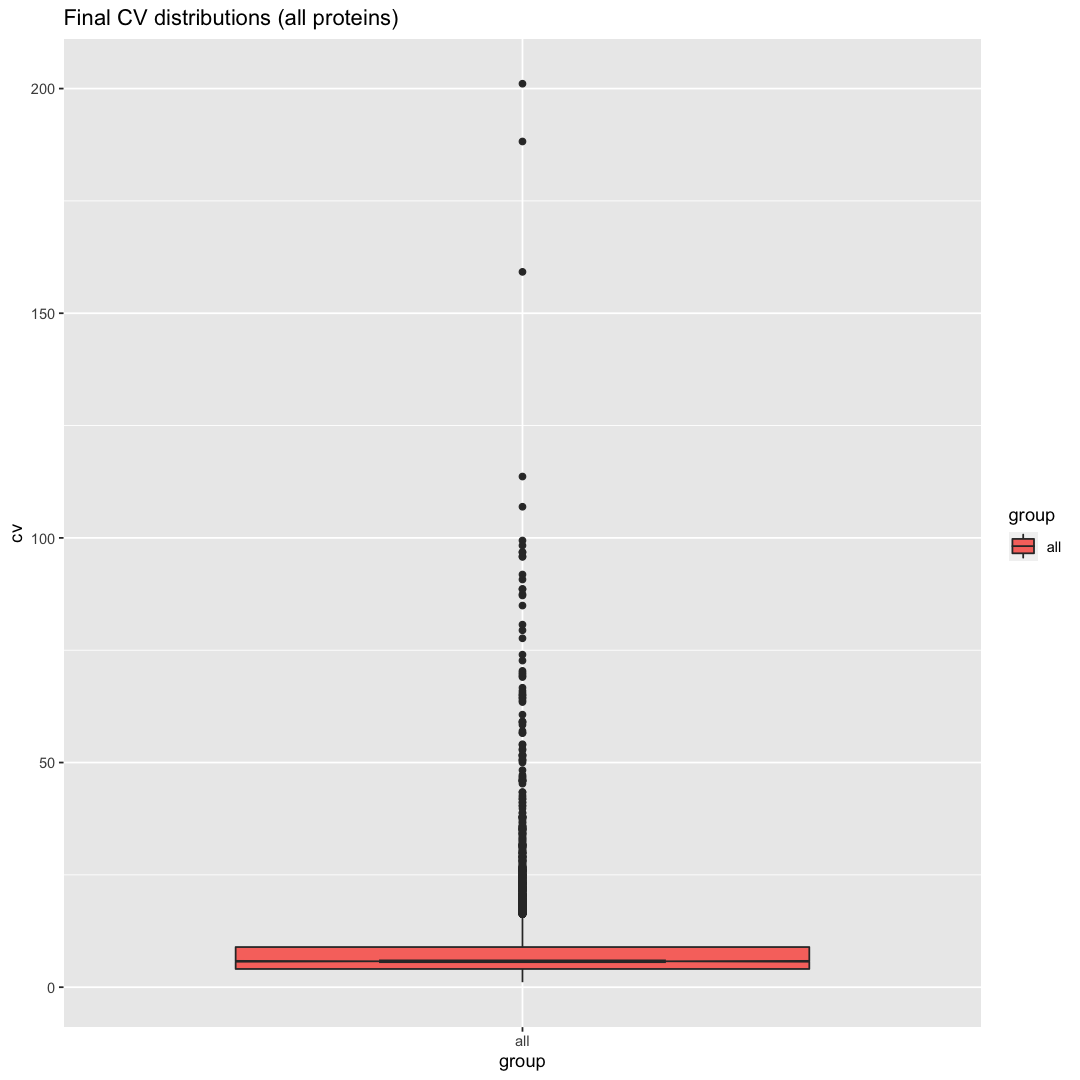

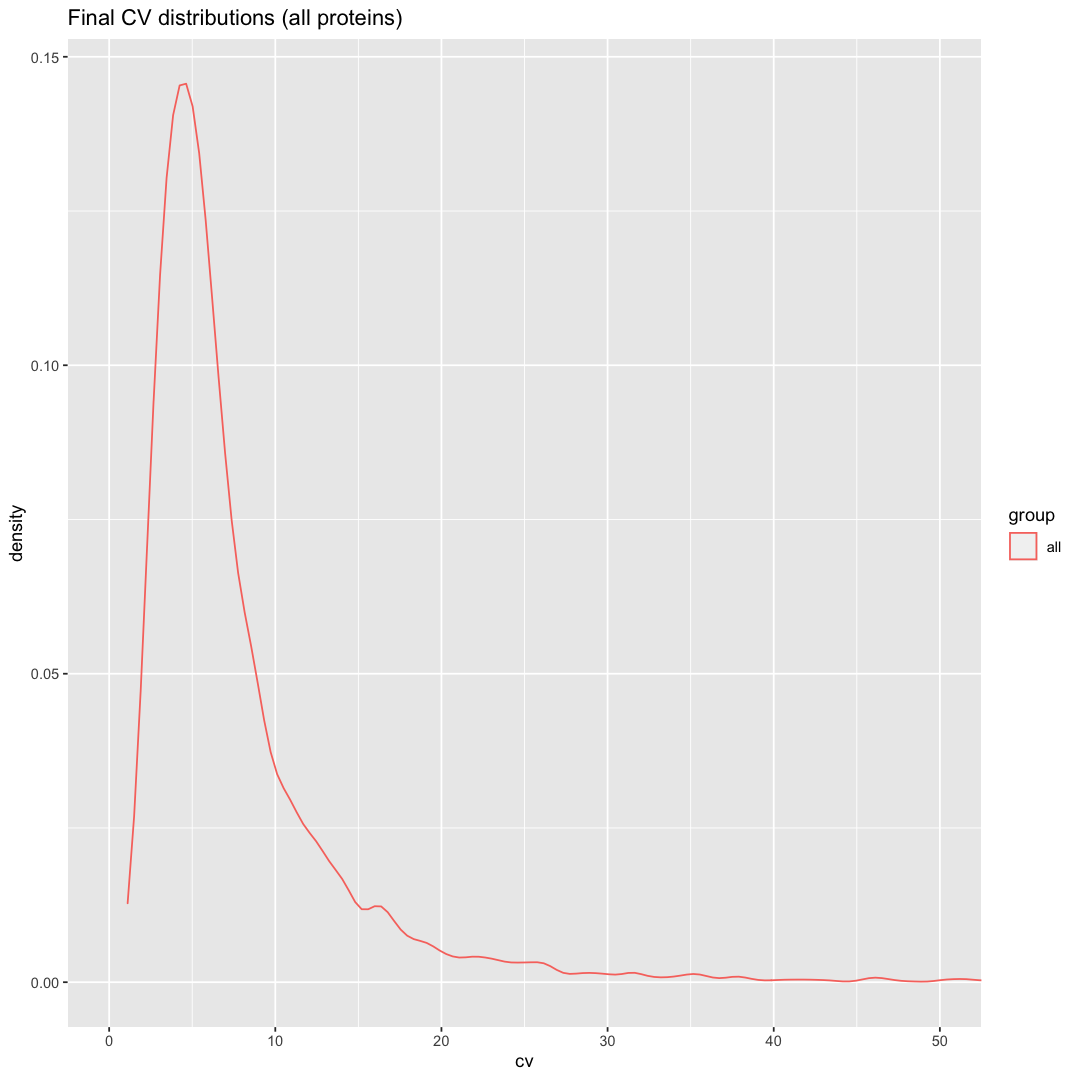

In [10]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv_start <- gather(cv_start_all, key = "group", value = "cv")

# traditional boxplots
ggplot(long_cv_start, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("Starting CV distributions (all proteins)")

# density plots
ggplot(long_cv_start, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 50)) +
  ggtitle("Starting CV distributions (all proteins)")

# need long form for ggplot
long_cv_tmm <- gather(cv_tmm_all, key = "group", value = "cv") 

# traditional boxplots
ggplot(long_cv_tmm, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("Final CV distributions (all proteins)")

# density plots
ggplot(long_cv_tmm, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 50)) +
  ggtitle("Final CV distributions (all proteins)")

### CV distribution density plots improve

## <a name="scatter_plots"></a>Compare samples within each biological condition

We can also look at each biological condition with a multi-panel scatter plot grid and see how similar the biological replicates are to each other. We will use the final TMM-normalized intensities. We will plot all proteins first, then the mouse proteins.

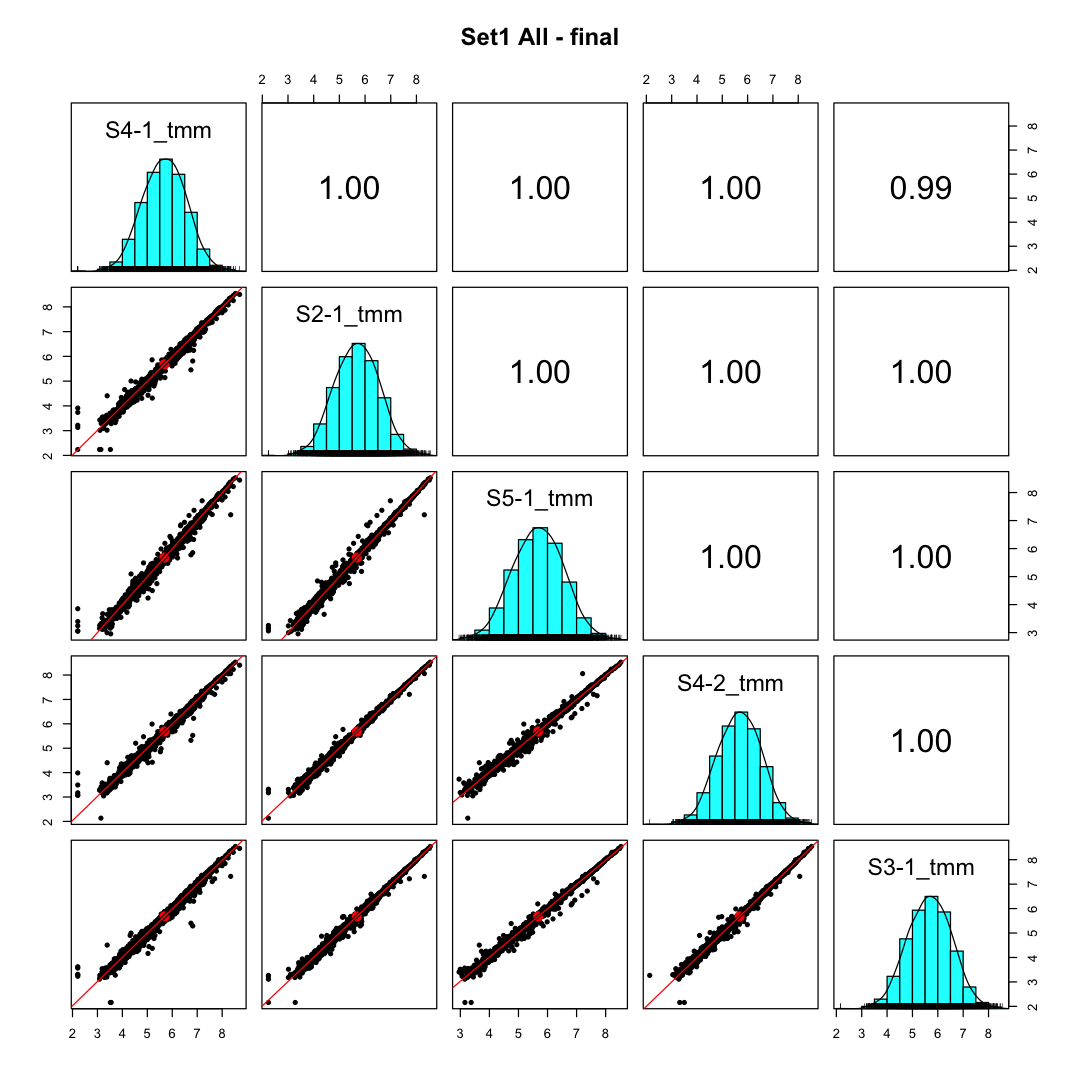

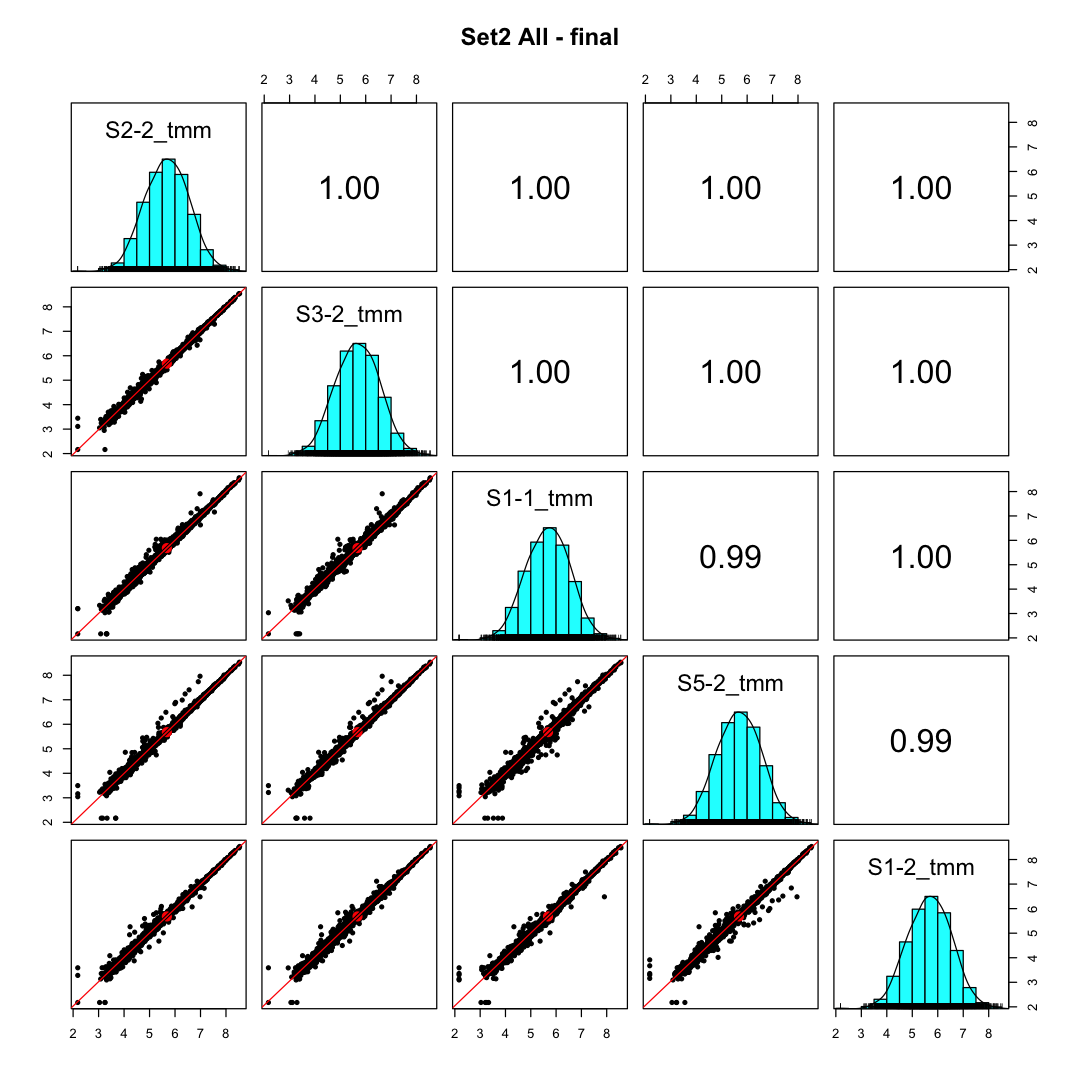

In [11]:
# multi-panel scatter plot grids, final data
pairs.panels(log10(tmt_tmm_all[1:5]), lm = TRUE, main = "Set1 All - final")
pairs.panels(log10(tmt_tmm_all[6:10]), lm = TRUE, main = "Set2 All - final")

### Mouse proteins only

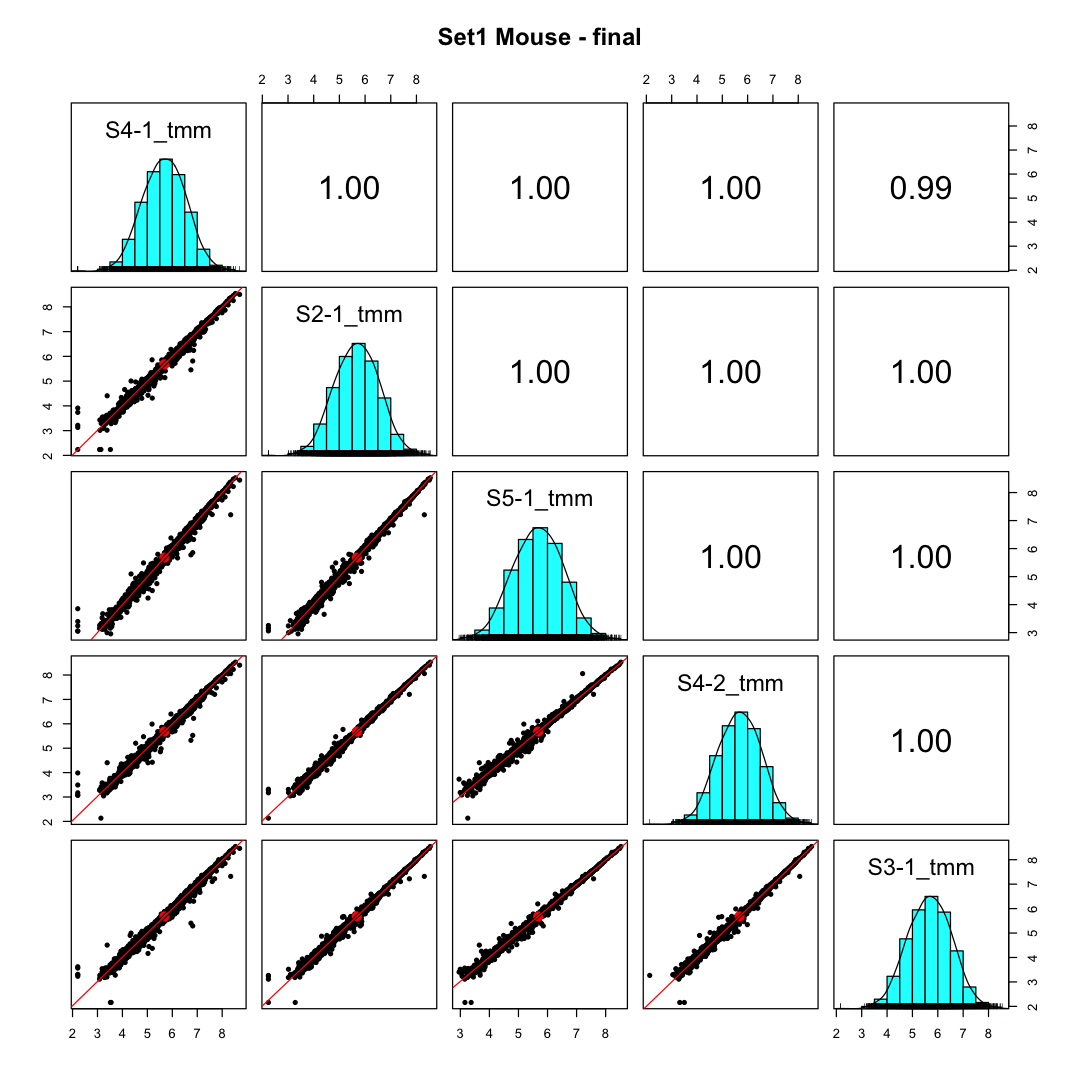

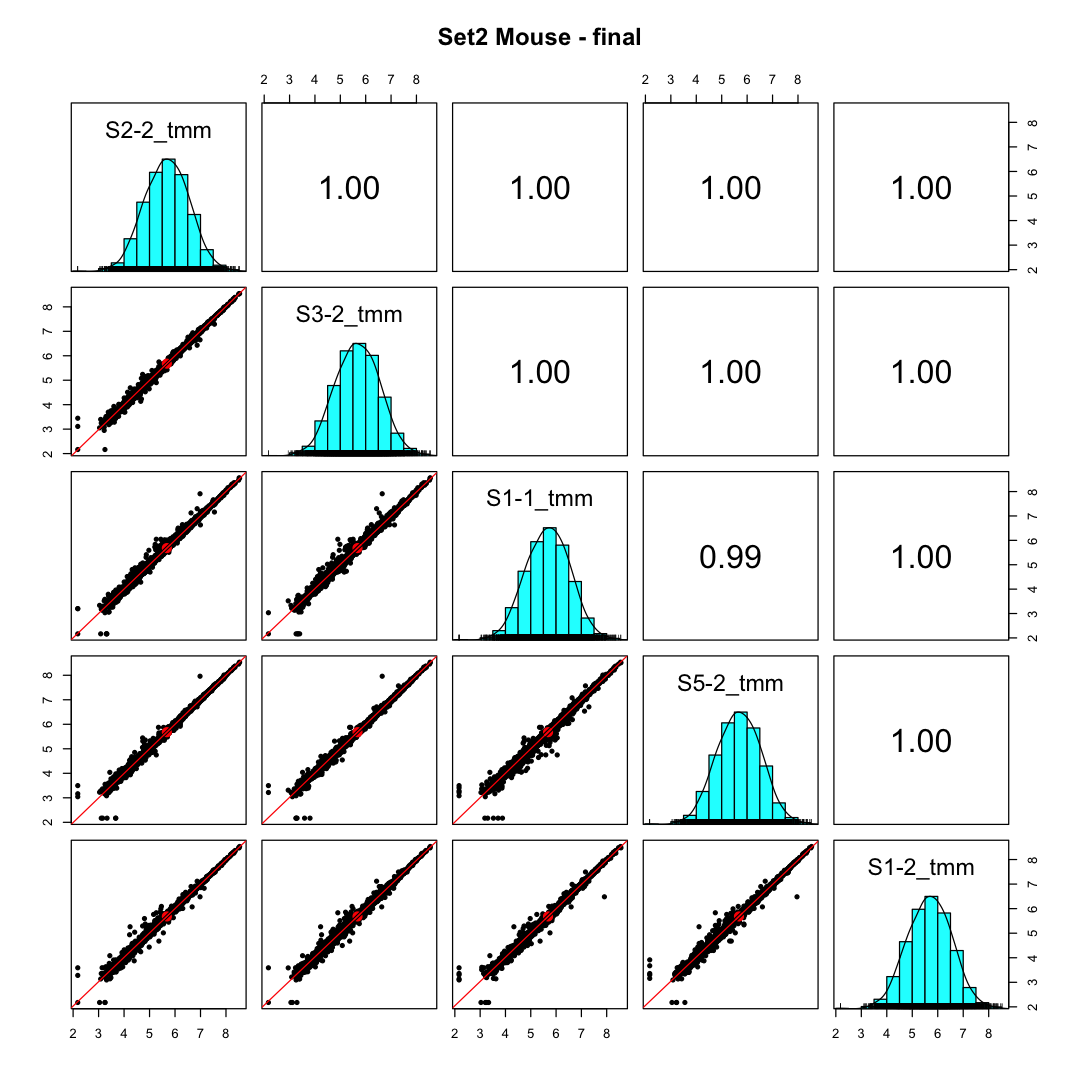

In [12]:
# multi-panel scatter plot grids, final data
pairs.panels(log10(tmt_tmm_mouse[1:5]), lm = TRUE, main = "Set1 Mouse - final")
pairs.panels(log10(tmt_tmm_mouse[6:10]), lm = TRUE, main = "Set2 Mouse - final")

## Compare averages of each group to each other

We do not have any groups to compare here. The mouse background should be a null experiment. We can take 5 samples at random, average the intensities, and plot that versus the average intensity of the other 5 channels.

In [13]:
# get two sets of 5 channels for plotting purposes
indices <- 1:10
set1 <- sample(indices, 5)
colnames(tmt_tmm_all)[set1]
set2 <- indices[-set1]
colnames(tmt_tmm_all)[set2]

[1] "S3-1_tmm" "S1-2_tmm" "S4-2_tmm" "S3-2_tmm" "S5-2_tmm"

[1] "S4-1_tmm" "S2-1_tmm" "S5-1_tmm" "S2-2_tmm" "S1-1_tmm"

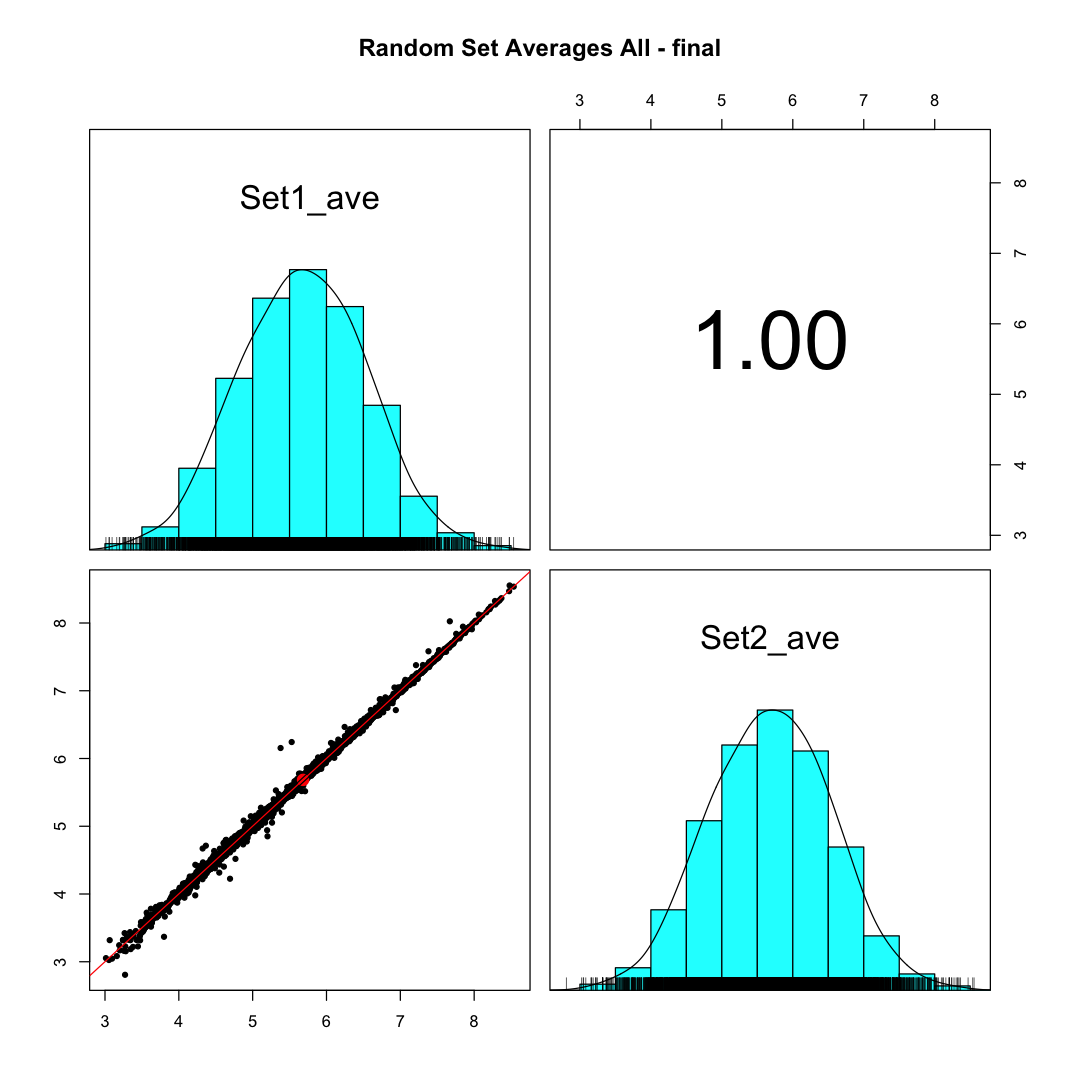

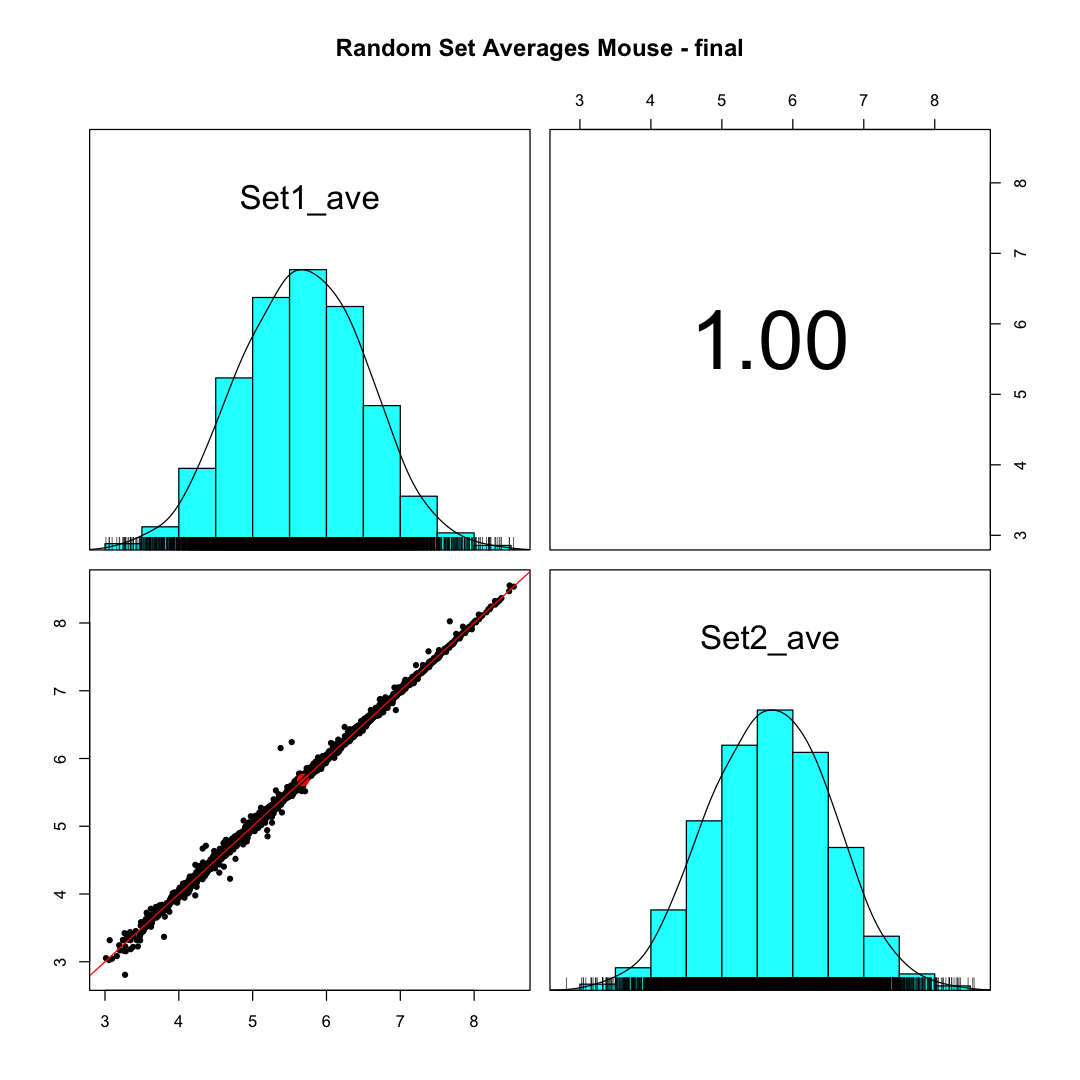

In [14]:
# make a scatter plot grid for the group averages
pairs.panels(log10(cbind(Set1_ave = rowMeans(tmt_tmm_all[set1]),
                         Set2_ave = rowMeans(tmt_tmm_all[set2]))),
             lm = TRUE, main = "Random Set Averages All - final")

pairs.panels(log10(cbind(Set1_ave = rowMeans(tmt_tmm_mouse[set1]),
                         Set2_ave = rowMeans(tmt_tmm_mouse[set2]))),
             lm = TRUE, main = "Random Set Averages Mouse - final")

### Mouse background looks constant

Animal samples tend to be more reproducible compared to human samples. It also seems that brain samples from either species are also more similar across biological replicates than are many other tissues. We have very low median CVs, and the scatter plots are very tight to the diagonal over almost 6 decades of intensities (3x10^5). 

## <a name="summary"></a> Summary

Quality control checks seem okay. We can move on to the statistical testing in a new notebook.

## Log the session information

In [15]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_2.0.7     edgeR_3.24.3    limma_3.38.3    scales_1.1.1   
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_1.0.2     purrr_0.3.4    
 [9] readr_1.3.1     tidyr_1.1.1     tibble_3.0.3    ggplot2_3.3.2  
[13] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5       locfit_1.5-9.4   lubridate_1.7.9  lattice_0.20-41 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.8  reprex_0.3.0    
[13] evaluate_0